In [24]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8')
%matplotlib inline

# Bank Customer Segmentation Analysis - Student Exercise

In this lab, you will implement customer segmentation using K-means clustering. You'll learn how to:
1. Preprocess data for clustering
2. Perform and visualize dimensionality reduction
3. Implement K-means clustering from scratch
4. Evaluate clustering results

Follow the instructions in each section and fill in the code where indicated.

In [25]:
# Load Data and Preprocess
def load_data(filepath):
    df = pd.read_csv(filepath, sep=';').copy()
    categorical_cols = ['job', 'marital', 'education', 'default', 'housing',
                       'loan', 'contact', 'month', 'poutcome', 'y']
    encoder = LabelEncoder()
    for col in categorical_cols:
        df[col] = encoder.fit_transform(df[col])
    features = ['age', 'balance', 'campaign', 'previous', 'job', 'education',
               'housing', 'loan', 'default']
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df[features])
    return X_scaled, df

#================ FOR PCA Dimensionality reduction =========
# Apply PCA for Dimensionality Reduction
def apply_pca(x, n_components):
    pca = PCA(n_components=n_components)
    transformed = pca.fit_transform(x)
    return transformed, pca

#================ FOR K-Means ===============================
# Find Optimal Clusters for KMeans (Elbow Method) 
def find_optimal_clusters(x, max_clusters=10):
    inertias = []
    for k in range(1, max_clusters + 1):
        model = KMeans(n_clusters=k, n_init=10, random_state=42)
        model.fit(x)
        inertias.append(model.inertia_)
    return inertias

# Perform KMeans Clustering 
# Change None to the number of n_clusters value from the elbow method
def perform_kmeans_clustering(x, n_clusters=None):
    if n_clusters is None:
        raise ValueError("n_clusters must be specified for KMeans clustering")
    model = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)
    labels = model.fit_predict(x)
    return model, labels

#================ FOR Agglomerative ===============================
# Perform Agglomerative Clustering 
# Change None to the number of n_clusters value from the elbow method
def perform_agglomerative_clustering(x, n_clusters=None):
    if n_clusters is None:
        raise ValueError("n_clusters must be specified for Agglomerative clustering")
    model = AgglomerativeClustering(n_clusters=n_clusters)
    labels = model.fit_predict(x)
    return model, labels

#================FOR Dendrogram===============================
# Get Linkages for Dendrogram
def get_linkages(x):
    return linkage(x, method='ward')

# Plot Dendrogram
def plot_dendrogram(linked):
    plt.figure(figsize=(12, 6))
    dendrogram(linked)
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('Samples')
    plt.ylabel('Distance')
    plt.show()

## 1. Data Loading and Preprocessing

First, complete the data preprocessing function below. You need to:
1. Load the data
2. Handle categorical variables
3. Scale numerical features

Data shape: (45211, 9)


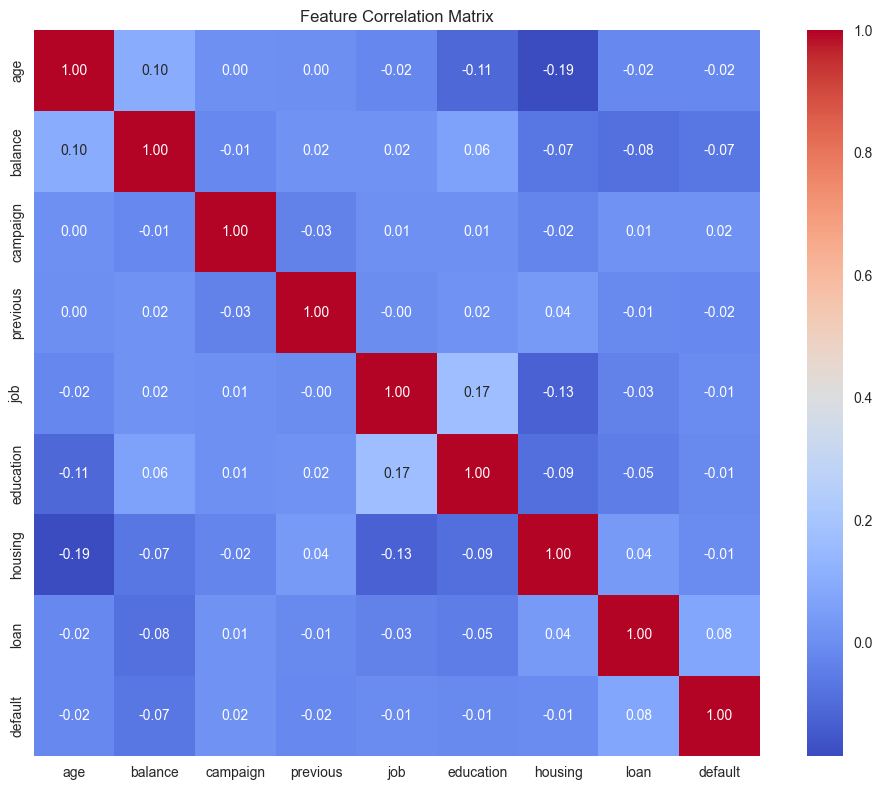

In [26]:
def load_data(filepath):
    """Load and preprocess the bank marketing dataset.

    TODO:
    1. Load the CSV file (hint: it uses semicolon separator)
    2. Convert categorical columns to numerical using LabelEncoder
    3. Scale the features using StandardScaler
    """
    # Your code here:
    # Load data
    df = pd.read_csv(filepath, sep=';').copy()

    # List of categorical columns to encode
    categorical_cols = ['job', 'marital', 'education', 'default', 'housing', 
                       'loan', 'contact', 'month', 'poutcome', 'y']

    # TODO: Apply label encoding to categorical columns
    encoder = LabelEncoder()
    for col in categorical_cols:
        df[col] = encoder.fit_transform(df[col])

    # Select features for clustering
    features = ['age', 'balance', 'campaign', 'previous', 'job', 'education', 
               'housing', 'loan', 'default']
    X = df[features]

    # TODO: Scale the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    return X_scaled, df

# Load and preprocess the data
X_scaled, data = load_data('bank-full.csv')
print("Data shape:", X_scaled.shape)

# Feature correlation matrix
corr_features = ['age', 'balance', 'campaign', 'previous', 'job', 'education',
                  'housing', 'loan', 'default']
corr_matrix = data[corr_features].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

In [27]:
class KMeansClustering:
    """Minimal K-means skeleton for students to implement.

    Students should implement the core methods below:
    - _initialize_centroids
    - _assign_clusters
    - _update_centroids
    - fit

    Keep implementations simple and readable; tests and visualization code will
    use these methods once implemented.
    """
    def __init__(self, n_clusters=3, max_iters=100, random_state=42, tol=1e-4):
        self.n_clusters = n_clusters
        self.max_iters = max_iters
        self.random_state = random_state
        self.tol = tol
        self.centroids = None
        self.labels = None
        self._rng = None

    def _initialize_centroids(self, X):
        """Initialize centroids.

        TODO (student):
        - Randomly select `n_clusters` distinct points from X as initial centroids.
        - Return an array of shape (n_clusters, n_features).
        Hint: Use np.random.choice to pick indices.
        """
        if self._rng is None:
            self._rng = np.random.default_rng(self.random_state)
        if self.n_clusters > X.shape[0]:
            raise ValueError("n_clusters cannot exceed number of samples")
        indices = self._rng.choice(X.shape[0], size=self.n_clusters, replace=False)
        return X[indices].astype(float, copy=True)

    def _assign_clusters(self, X):
        """Assign each sample in X to the nearest centroid.

        TODO (student):
        - Compute distance from each point to each centroid (Euclidean)
        - Return an integer array of shape (n_samples,) with cluster labels
        Hint: np.linalg.norm with axis manipulation or broadcasting helps here.
        """
        distances = np.linalg.norm(X[:, np.newaxis, :] - self.centroids[np.newaxis, :, :], axis=2)
        return np.argmin(distances, axis=1)

    def _update_centroids(self, X, labels):
        """Recompute centroids as the mean of points assigned to each cluster.

        TODO (student):
        - For each cluster id in 0..n_clusters-1 compute the mean of points
          assigned to that cluster. If a cluster has no points, consider reinitializing
          its centroid (or leave unchanged) — discuss in your report.
        - Return an array of shape (n_clusters, n_features).
        """
        new_centroids = np.zeros_like(self.centroids)
        for cluster_id in range(self.n_clusters):
            members = X[labels == cluster_id]
            if members.size == 0:
                replacement_idx = self._rng.choice(X.shape[0])
                new_centroids[cluster_id] = X[replacement_idx]
            else:
                new_centroids[cluster_id] = members.mean(axis=0)
        return new_centroids

    def fit(self, X):
        """Run K-means until convergence or max_iters.

        TODO (student):
        - Initialize centroids
        - Loop: assign clusters, update centroids
        - Stop early if centroids do not change (or change below a tiny threshold)
        - Store final labels in self.labels and centroids in self.centroids
        - Return self
        """
        X = np.asarray(X, dtype=float)
        self._rng = np.random.default_rng(self.random_state)
        self.centroids = self._initialize_centroids(X)
        for _ in range(self.max_iters):
            labels = self._assign_clusters(X)
            new_centroids = self._update_centroids(X, labels)
            shift = np.linalg.norm(self.centroids - new_centroids)
            self.centroids = new_centroids
            self.labels = labels
            if shift <= self.tol:
                break
        return self

    def predict(self, X):
        """Assign cluster labels to X using the learned centroids.

        Implementation may call _assign_clusters but should error if centroids
        are not yet initialized (i.e., if fit wasn't called).
        """
        if self.centroids is None:
            raise ValueError("Model has not been fitted yet. Call fit(X) first.")
        return self._assign_clusters(X)

## 2. Dimensionality Reduction

Before clustering, we often reduce the dimensionality of our data for better visualization and performance. Implement PCA below:

Shape after PCA: (45211, 2)


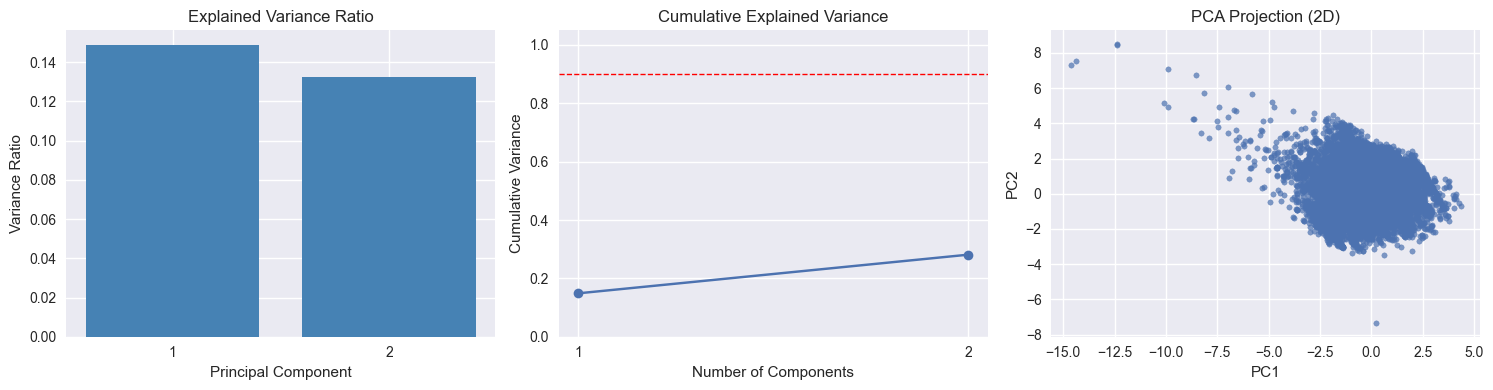

In [28]:
def apply_pca(X, n_components=2):
    """Apply PCA for dimensionality reduction.

    TODO:
    1. Initialize and fit PCA
    2. Transform the data
    3. Create visualizations to understand:
       - Explained variance ratio
       - Cumulative explained variance
       - Data distribution in 2D
    """
    # Your code here:
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)

    # TODO: Create visualization
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    # Plot explained variance
    variance_ratio = pca.explained_variance_ratio_
    axes[0].bar(range(1, len(variance_ratio) + 1), variance_ratio, color='steelblue')
    axes[0].set_title('Explained Variance Ratio')
    axes[0].set_xlabel('Principal Component')
    axes[0].set_ylabel('Variance Ratio')
    axes[0].set_xticks(range(1, len(variance_ratio) + 1))

    # Plot cumulative explained variance
    cumulative_variance = np.cumsum(variance_ratio)
    axes[1].plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
    axes[1].axhline(0.9, color='red', linestyle='--', linewidth=1)
    axes[1].set_title('Cumulative Explained Variance')
    axes[1].set_xlabel('Number of Components')
    axes[1].set_ylabel('Cumulative Variance')
    axes[1].set_xticks(range(1, len(cumulative_variance) + 1))
    axes[1].set_ylim(0, 1.05)

    # Plot data in 2D
    if X_pca.shape[1] >= 2:
        axes[2].scatter(X_pca[:, 0], X_pca[:, 1], s=15, alpha=0.7)
        axes[2].set_xlabel('PC1')
        axes[2].set_ylabel('PC2')
        axes[2].set_title('PCA Projection (2D)')
    else:
        axes[2].scatter(range(X_pca.shape[0]), X_pca[:, 0], s=15, alpha=0.7)
        axes[2].set_xlabel('Sample Index')
        axes[2].set_ylabel('PC1')
        axes[2].set_title('PCA Projection (1D)')

    plt.tight_layout()

    return X_pca

# Apply PCA
X_pca = apply_pca(X_scaled)
print("Shape after PCA:", X_pca.shape)

## 3. Clustering Evaluation

Implement functions to evaluate the quality of your clustering results:

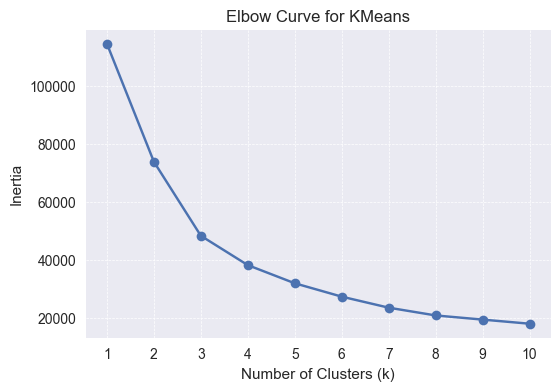

C:\Users\cpans\AppData\Local\Temp\ipykernel_21976\4231756027.py:83: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette='viridis', ax=axes[1, 0])
C:\Users\cpans\AppData\Local\Temp\ipykernel_21976\4231756027.py:89: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=silhouette_df, x='cluster', y='silhouette', palette='viridis', ax=axes[1, 1])


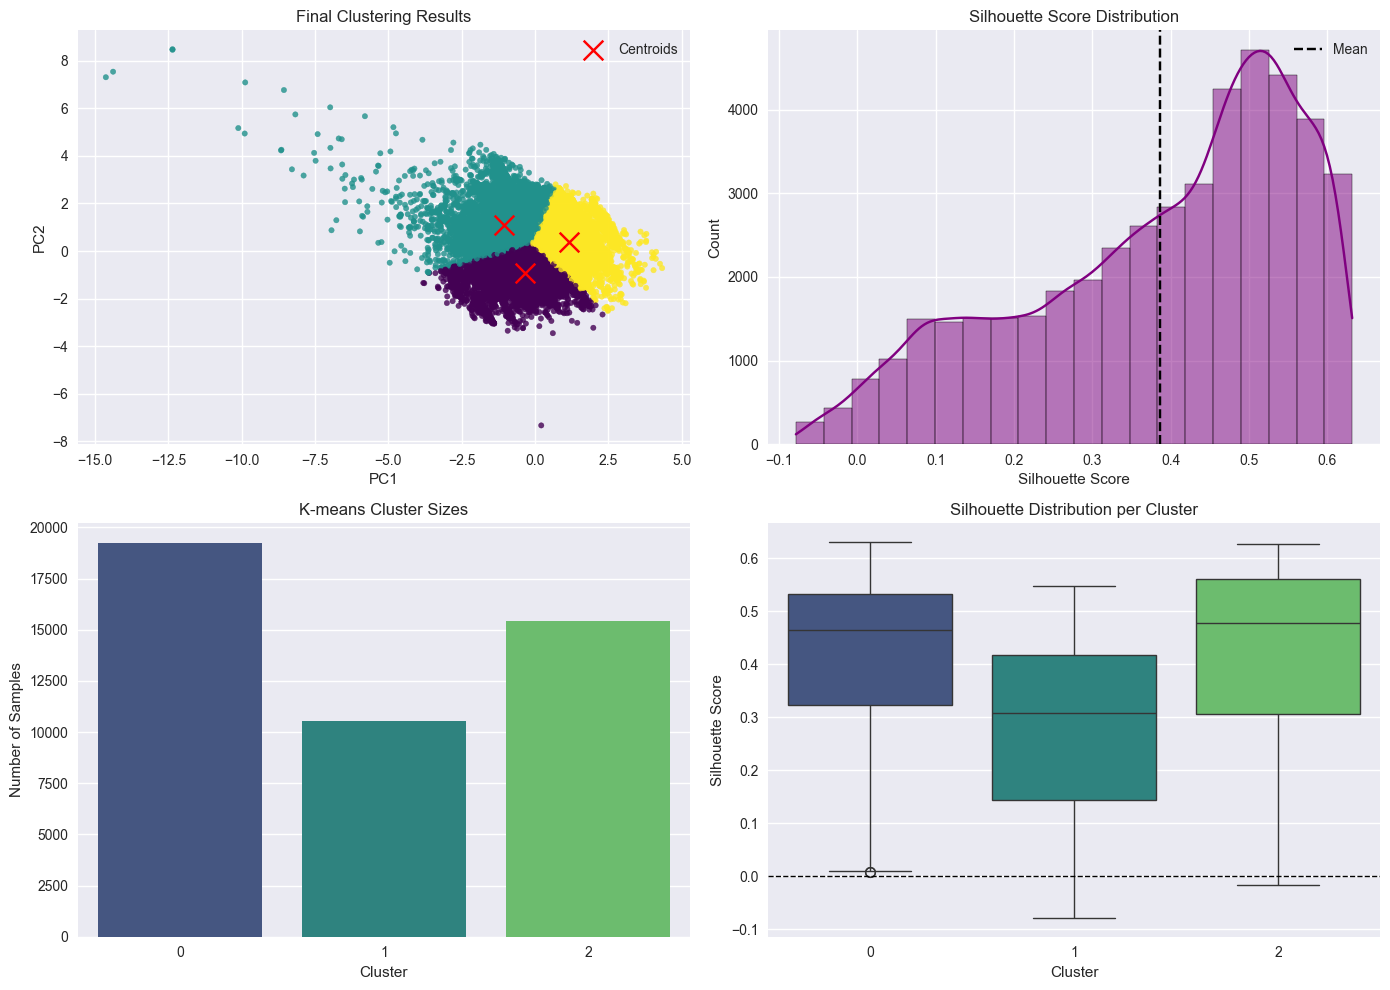


Clustering Evaluation:
Inertia: 48179.64
Silhouette Score: 0.39


In [29]:
def calculate_inertia(X, labels, centroids):
    """Calculate the within-cluster sum of squares (inertia).

    TODO:
    1. For each cluster, calculate the sum of squared distances
       between points and their centroid
    2. Sum up all cluster distances
    """
    # Your code here
    inertia = 0.0
    for cluster_id in range(centroids.shape[0]):
        members = X[labels == cluster_id]
        if members.size == 0:
            continue
        diffs = members - centroids[cluster_id]
        inertia += np.sum(diffs ** 2)
    return inertia

def plot_elbow_curve(X, max_k=10):
    """Plot the elbow curve to find optimal number of clusters.

    TODO:
    1. Try different values of k (1 to max_k)
    2. Calculate inertia for each k
    3. Plot k vs inertia
    4. Help identify the 'elbow' point
    """
    # Your code here
    inertias = []
    K = range(1, max_k + 1)

    # Calculate inertia for different k values
    for k in K:
        kmeans_model = KMeansClustering(n_clusters=k, random_state=42)
        kmeans_model.fit(X)
        inertia_value = calculate_inertia(X, kmeans_model.labels, kmeans_model.centroids)
        inertias.append(inertia_value)

    # Create elbow plot
    plt.figure(figsize=(6, 4))
    plt.plot(list(K), inertias, marker='o')
    plt.title('Elbow Curve for KMeans')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Inertia')
    plt.xticks(list(K))
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.show()

    return inertias

# Try different numbers of clusters
inertias = plot_elbow_curve(X_pca)

# Apply final clustering
kmeans = KMeansClustering(n_clusters=3)  # Try different values based on elbow curve
kmeans.fit(X_pca)

cluster_labels = kmeans.labels
silhouette_values = silhouette_samples(X_pca, cluster_labels)
cluster_counts = pd.Series(cluster_labels).value_counts().sort_index()
silhouette_df = pd.DataFrame({'cluster': cluster_labels, 'silhouette': silhouette_values})

# Visualize final results
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot clusters
axes[0, 0].scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='viridis', s=15, alpha=0.8)
axes[0, 0].scatter(kmeans.centroids[:, 0], kmeans.centroids[:, 1], 
                   c='red', marker='x', s=200, label='Centroids')
axes[0, 0].set_title('Final Clustering Results')
axes[0, 0].set_xlabel('PC1')
axes[0, 0].set_ylabel('PC2')
axes[0, 0].legend()

# Overall silhouette distribution
sns.histplot(silhouette_values, bins=20, kde=True, color='purple', ax=axes[0, 1])
axes[0, 1].axvline(np.mean(silhouette_values), color='black', linestyle='--', label='Mean')
axes[0, 1].set_title('Silhouette Score Distribution')
axes[0, 1].set_xlabel('Silhouette Score')
axes[0, 1].legend()

# Cluster sizes
sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette='viridis', ax=axes[1, 0])
axes[1, 0].set_title('K-means Cluster Sizes')
axes[1, 0].set_xlabel('Cluster')
axes[1, 0].set_ylabel('Number of Samples')

# Silhouette per cluster
sns.boxplot(data=silhouette_df, x='cluster', y='silhouette', palette='viridis', ax=axes[1, 1])
axes[1, 1].axhline(0, color='black', linestyle='--', linewidth=1)
axes[1, 1].set_title('Silhouette Distribution per Cluster')
axes[1, 1].set_xlabel('Cluster')
axes[1, 1].set_ylabel('Silhouette Score')

plt.tight_layout()
plt.show()

# Calculate and print evaluation metrics
inertia = calculate_inertia(X_pca, cluster_labels, kmeans.centroids)
silhouette = silhouette_score(X_pca, cluster_labels)

print("\nClustering Evaluation:")
print(f"Inertia: {inertia:.2f}")
print(f"Silhouette Score: {silhouette:.2f}")

## 4. Recursive Bisecting K-means (Student exercise)

This is an optional exercise for students who want to explore a hierarchical variant of K-means.

Task: implement a concise bisecting K-means procedure that recursively splits clusters into two until a target number of clusters is reached.

Learning goals:
- Understand how repeated binary splits can form a hierarchical clustering
- Practice applying K-means on subclusters and tracking labels/centroids

Hints:
- You can use sklearn's KMeans(k=2) for the binary split step, or reuse your `KMeansClustering` implementation.
- Keep label bookkeeping simple: use increasing integer labels for new clusters.
- Store split metadata (parent -> left/right) to enable a tree visualization later.

C:\Users\cpans\AppData\Local\Temp\ipykernel_21976\2696714422.py:117: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=bisect_cluster_counts.index, y=bisect_cluster_counts.values, palette='viridis', ax=axes[1, 0])
C:\Users\cpans\AppData\Local\Temp\ipykernel_21976\2696714422.py:123: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=bisect_silhouette_df, x='cluster', y='silhouette', palette='viridis', ax=axes[1, 1])


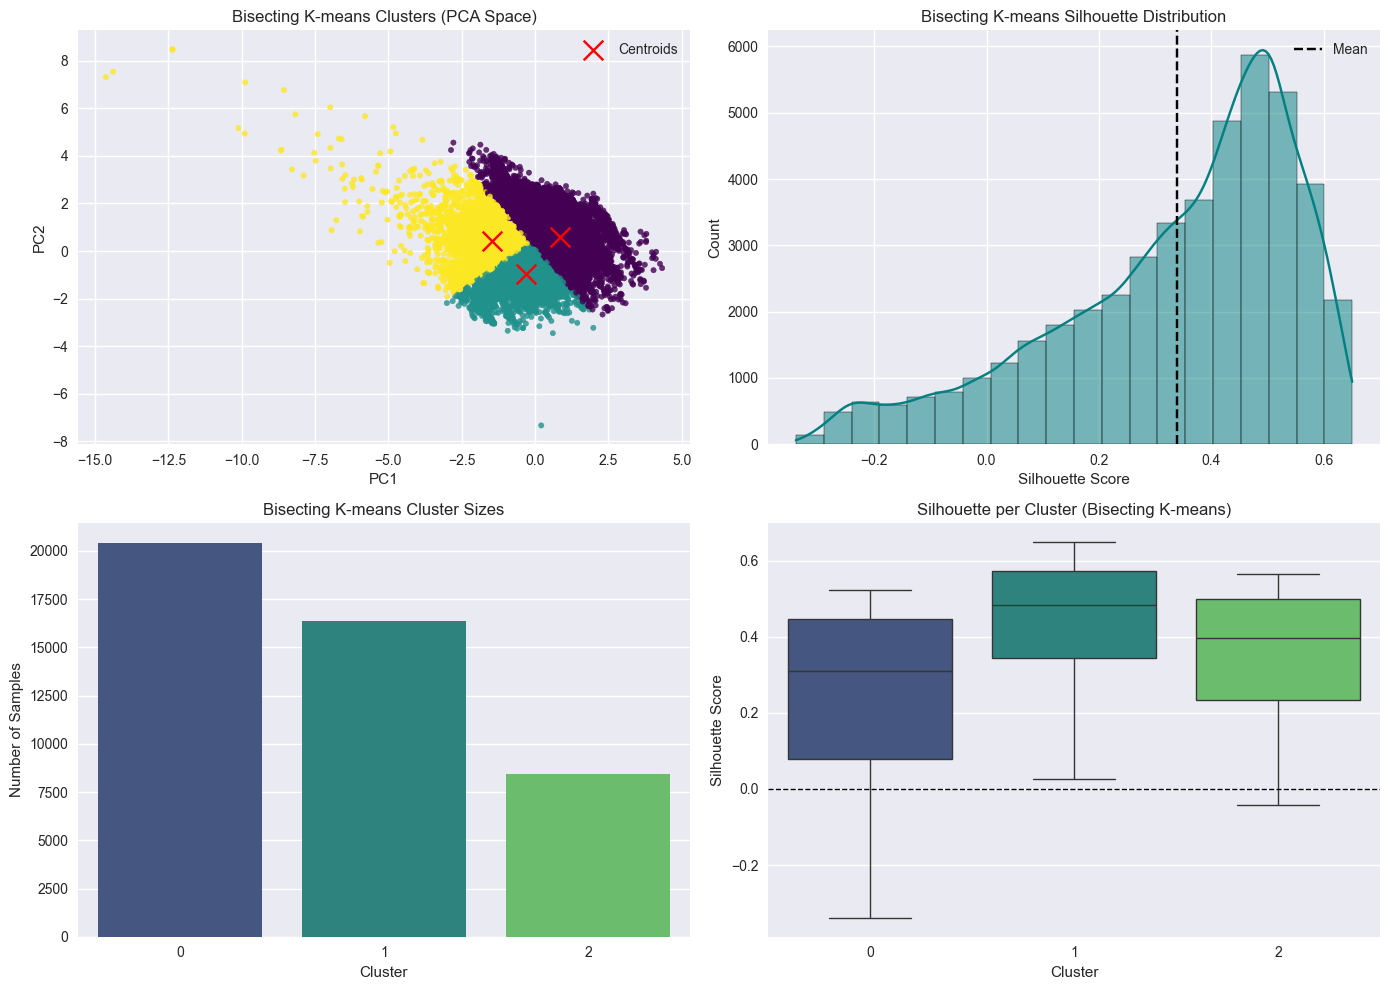

Bisecting K-means cluster sizes (counts):
0    20434
1    16348
2     8429
Name: count, dtype: int64
Mean silhouette score: 0.34


In [30]:
class BisectingKMeans:
    """Concise skeleton for students to implement a bisecting K-means algorithm.

    Students should implement `fit_predict` to recursively split clusters until
    `n_clusters` is reached.
    """
    def __init__(self, n_clusters, random_state=42):
        self.n_clusters = n_clusters
        self.random_state = random_state
        self.labels_ = None
        # Optional: store mapping parent -> (left_label, right_label)
        self.split_tree = {}
        # Optional: store centroids per cluster id
        self.centers_ = {}

    def fit_predict(self, X):
        """Recursively bisect clusters until `n_clusters` is reached.

        TODO (student):
        - Start with all points assigned to label 0.
        - While number of unique labels < n_clusters:
            - Select a cluster to split (e.g., the largest cluster by size)
            - Run a binary KMeans (k=2) on the points in that cluster
            - Assign new labels (keep one child label as the original, give the other a new id)
            - Record parent -> (left, right) in `self.split_tree` and centroids in `self.centers_`
        - Set and return `self.labels_` (numpy array of length n_samples)

        Hints:
        - Use sklearn.cluster.KMeans(n_clusters=2, random_state=self.random_state) for the split step
        - Keep a counter for new label ids and increment when creating a new cluster
        - Use boolean indexing to operate on subsets of X efficiently
        """
        X = np.asarray(X, dtype=float)
        n_samples = X.shape[0]
        if self.n_clusters < 1:
            raise ValueError("n_clusters must be at least 1")
        if n_samples == 0:
            self.labels_ = np.array([], dtype=int)
            return self.labels_
        labels = np.zeros(n_samples, dtype=int)
        clusters = {0: np.arange(n_samples)}
        self.centers_[0] = X.mean(axis=0)
        next_label = 1
        rng = np.random.default_rng(self.random_state)

        while len(clusters) < self.n_clusters:
            cluster_id = max(clusters, key=lambda cid: clusters[cid].size)
            cluster_indices = clusters[cluster_id]
            if cluster_indices.size <= 1:
                break
            subset = X[cluster_indices]
            splitter = KMeans(n_clusters=2, n_init=10, random_state=self.random_state)
            split_labels = splitter.fit_predict(subset)

            left_mask = split_labels == 0
            right_mask = split_labels == 1
            if not left_mask.any() or not right_mask.any():
                rng.shuffle(cluster_indices)
                midpoint = cluster_indices.size // 2
                left_mask = np.zeros(cluster_indices.size, dtype=bool)
                left_mask[:midpoint] = True
                right_mask = ~left_mask

            left_indices = cluster_indices[left_mask]
            right_indices = cluster_indices[right_mask]
            new_label = next_label
            next_label += 1

            labels[left_indices] = cluster_id
            labels[right_indices] = new_label

            clusters[cluster_id] = left_indices
            clusters[new_label] = right_indices
            self.split_tree[cluster_id] = (cluster_id, new_label)
            self.centers_[cluster_id] = X[left_indices].mean(axis=0)
            self.centers_[new_label] = X[right_indices].mean(axis=0)

            if len(clusters) >= self.n_clusters:
                break

        self.labels_ = labels
        return self.labels_

# Example (for instructor use only):
# bisect = BisectingKMeans(n_clusters=4)
# labels = bisect.fit_predict(X_pca)
# plt.scatter(X_pca[:,0], X_pca[:,1], c=labels)

# --- Bisecting K-means evaluation ---
bisect = BisectingKMeans(n_clusters=3, random_state=42)
bisect_labels = bisect.fit_predict(X_pca)
bisect_cluster_counts = pd.Series(bisect_labels).value_counts().sort_index()
bisect_silhouette_values = silhouette_samples(X_pca, bisect_labels)
bisect_silhouette_df = pd.DataFrame({'cluster': bisect_labels, 'silhouette': bisect_silhouette_values})
bisect_centroids = np.vstack([bisect.centers_[cid] for cid in sorted(bisect.centers_)])
bisect_silhouette_mean = np.mean(bisect_silhouette_values)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Scatter plot with centroids
axes[0, 0].scatter(X_pca[:, 0], X_pca[:, 1], c=bisect_labels, cmap='viridis', s=15, alpha=0.8)
axes[0, 0].scatter(bisect_centroids[:, 0], bisect_centroids[:, 1], 
                   c='red', marker='x', s=200, label='Centroids')
axes[0, 0].set_title('Bisecting K-means Clusters (PCA Space)')
axes[0, 0].set_xlabel('PC1')
axes[0, 0].set_ylabel('PC2')
axes[0, 0].legend()

# Overall silhouette distribution
sns.histplot(bisect_silhouette_values, bins=20, kde=True, color='teal', ax=axes[0, 1])
axes[0, 1].axvline(bisect_silhouette_mean, color='black', linestyle='--', label='Mean')
axes[0, 1].set_title('Bisecting K-means Silhouette Distribution')
axes[0, 1].set_xlabel('Silhouette Score')
axes[0, 1].legend()

# Cluster size comparison
sns.barplot(x=bisect_cluster_counts.index, y=bisect_cluster_counts.values, palette='viridis', ax=axes[1, 0])
axes[1, 0].set_title('Bisecting K-means Cluster Sizes')
axes[1, 0].set_xlabel('Cluster')
axes[1, 0].set_ylabel('Number of Samples')

# Silhouette per cluster
sns.boxplot(data=bisect_silhouette_df, x='cluster', y='silhouette', palette='viridis', ax=axes[1, 1])
axes[1, 1].axhline(0, color='black', linestyle='--', linewidth=1)
axes[1, 1].set_title('Silhouette per Cluster (Bisecting K-means)')
axes[1, 1].set_xlabel('Cluster')
axes[1, 1].set_ylabel('Silhouette Score')

plt.tight_layout()
plt.show()

print('Bisecting K-means cluster sizes (counts):')
print(bisect_cluster_counts.sort_values(ascending=False))
print(f"Mean silhouette score: {bisect_silhouette_mean:.2f}")

## Bonus Challenges

If you've completed the main tasks, try these extensions:

1. Implement k-means++ initialization
   - Instead of random initialization, use the k-means++ algorithm
   - This should give better and more consistent results

2. Add cluster interpretation
   - Analyze the characteristics of each cluster
   - What features distinguish one cluster from another?
   - Create visualizations to show cluster properties

3. Try different distance metrics
   - Implement Manhattan distance instead of Euclidean
   - Compare the clustering results

4. Add outlier detection
   - Identify points far from all centroids
   - How might you handle these outliers?

Remember to document your code and explain your findings!